In [1]:
import os
import sys
import gc
# assuming data, models, engine in flicc directory:
flicc_path = os.path.realpath("__file__").split('grid_search')[0]
sys.path.append(flicc_path)
import torch
from data import ClimateDataset
from models import ClassificationModel
from engine import Engine

In [2]:
model_checkpoint='facebook/opt-350m'

In [3]:
results = {'test_acc':[],
           'test_f1':[],
           'eval_acc':[],
           'eval_f1':[],
           'wd':[]}

In [4]:
g = 4
lr = 5.0e-5
weight_decay = [0.1, 0.01]

for wd in weight_decay:
    print(f'Grid search {model_checkpoint}, learning rate {lr}, focal loss gamma {g}, weight decay {wd}')
    data = ClimateDataset(model_to_train=3,model_checkpoint=model_checkpoint,dataset_url=flicc_path,batch_size=16)
    data.setup_dataloaders()
    model = ClassificationModel(model_checkpoint=data.model_checkpoint,num_labels=data.num_labels)
    trainer = Engine(epochs=30,labels=data.labels)
    trainer.model = model.model
    trainer.dataset_encoded = data.dataset_encoded
    test_acc, test_f1, eval_acc, eval_f1 = trainer.run(lr=lr,
                                                       wd=wd,
                                                       train_dataloader=data.train_dataloader,
                                                       eval_dataloader=data.eval_dataloader,
                                                       test_dataloader=data.test_dataloader,
                                                       accumulation_steps=2,
                                                       focalloss=True,
                                                       gamma=g,
                                                       early_stop=3)
    results['test_acc'].append(test_acc)
    results['test_f1'].append(test_f1)
    results['eval_acc'].append(eval_acc)
    results['eval_f1'].append(eval_f1)
    results['wd'].append(wd)
    print('### '*10)
    print(results)
    print('### '*10)
    with torch.no_grad():
        torch.cuda.empty_cache()
    del data, model, trainer, test_acc, test_f1, eval_acc, eval_f1
    gc.collect()

Grid search facebook/opt-350m, learning rate 5e-05, focal loss gamma 4, weight decay 0.1


Map:   0%|          | 0/189 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-350m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


1 / 30: Train Loss:	7.2652	Val Loss:	1.7297	Accuracy:	0.3018	F1:	0.2574
2 / 30: Train Loss:	2.5267	Val Loss:	1.2339	Accuracy:	0.5828	F1:	0.5412
3 / 30: Train Loss:	1.8688	Val Loss:	1.9496	Accuracy:	0.1805	F1:	0.1906
4 / 30: Train Loss:	7.5547	Val Loss:	2.1772	Accuracy:	0.1095	F1:	0.0219
5 / 30: Train Loss:	6.5985	Val Loss:	2.3589	Accuracy:	0.0414	F1:	0.0088
No improvement for 3 epochs. Stopping early.
best (higgest macro f1-score) val results:
                         precision    recall  f1-score   support

             ad hominem       0.77      0.49      0.60        67
               anecdote       0.57      0.91      0.70        43
         cherry picking       0.59      0.54      0.56        56
      conspiracy theory       0.69      0.64      0.67        39
           fake experts       0.53      0.67      0.59        12
           false choice       0.27      0.92      0.42        13
      false equivalence       0.22      0.14      0.17        14
impossible expectations       0

Map:   0%|          | 0/338 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-350m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


1 / 30: Train Loss:	7.2469	Val Loss:	1.7115	Accuracy:	0.3136	F1:	0.2661
2 / 30: Train Loss:	2.5104	Val Loss:	1.2507	Accuracy:	0.5799	F1:	0.5396
3 / 30: Train Loss:	2.0736	Val Loss:	1.8145	Accuracy:	0.2811	F1:	0.1678
4 / 30: Train Loss:	6.7982	Val Loss:	2.2360	Accuracy:	0.0385	F1:	0.0082
5 / 30: Train Loss:	6.4868	Val Loss:	2.3272	Accuracy:	0.0385	F1:	0.0082
No improvement for 3 epochs. Stopping early.
best (higgest macro f1-score) val results:
                         precision    recall  f1-score   support

             ad hominem       0.81      0.43      0.56        67
               anecdote       0.59      0.91      0.72        43
         cherry picking       0.59      0.57      0.58        56
      conspiracy theory       0.68      0.67      0.68        39
           fake experts       0.53      0.67      0.59        12
           false choice       0.28      0.92      0.43        13
      false equivalence       0.18      0.14      0.16        14
impossible expectations       0

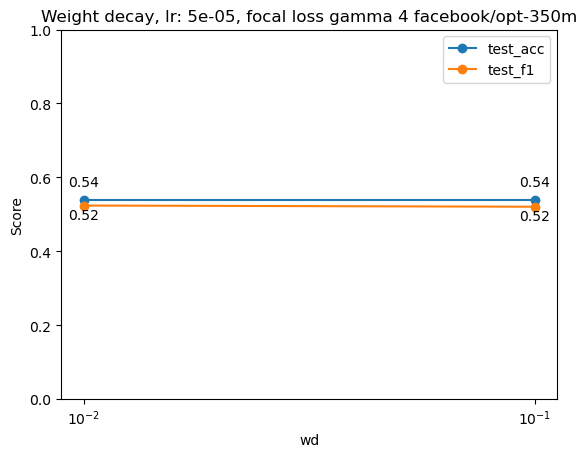

In [5]:
Engine.plot_grid_search(df=results,
                        title=f'Weight decay, lr: {lr}, focal loss gamma {g} {model_checkpoint}',
                        column='wd',
                        sci_format=True)

In [6]:
%reset -f